In [1]:
import os
os.chdir('/home/reggie/cosmo_learn')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from cosmo_learn.cosmo_learn import *
from astropy.cosmology import w0waCDM

import tensorflow as tf

2024-10-16 18:15:44.301459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### One mock

In [3]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, Ok0, w0, wa, s8 = 70, 0.3, 0, -1, 0, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, Ok0, w0, wa, s8 = 67.74, 0.3095, 0, -0.997, 0, 0.834
cosmo=w0waCDM(H0=H0, Om0=Om0, Ode0=1-Om0-Ok0, w0=w0, wa=wa) # baseline astropy model

gw_cosmo=CosmoLearn([H0, Om0, Ok0, w0, wa, s8], seed=14000605)
gw_cosmo.set_cosmo()

z_h, Hz_h, errHz_h=gw_cosmo.make_cosmic_chronometers_like()
z_sn, muz_sn, errmuz_sn=gw_cosmo.make_pantheon_plus_like()
z_bao, DVrdz_bao, errDVrdz_bao=gw_cosmo.make_desi1_like()
z_bs, dLz_bs, errdLz_bs=gw_cosmo.make_bright_sirens_mock(pop_model='Pop III', years=5)
z_g, fs8z_g, errfs8z_g=gw_cosmo.make_rsd_like(de_model='no pert', k2cs2=1e-10, hh=1e-10)

gw_cosmo.mock_data.keys()

dict_keys(['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', 'BrightSirens', 'RedshiftSpaceDistorsions'])

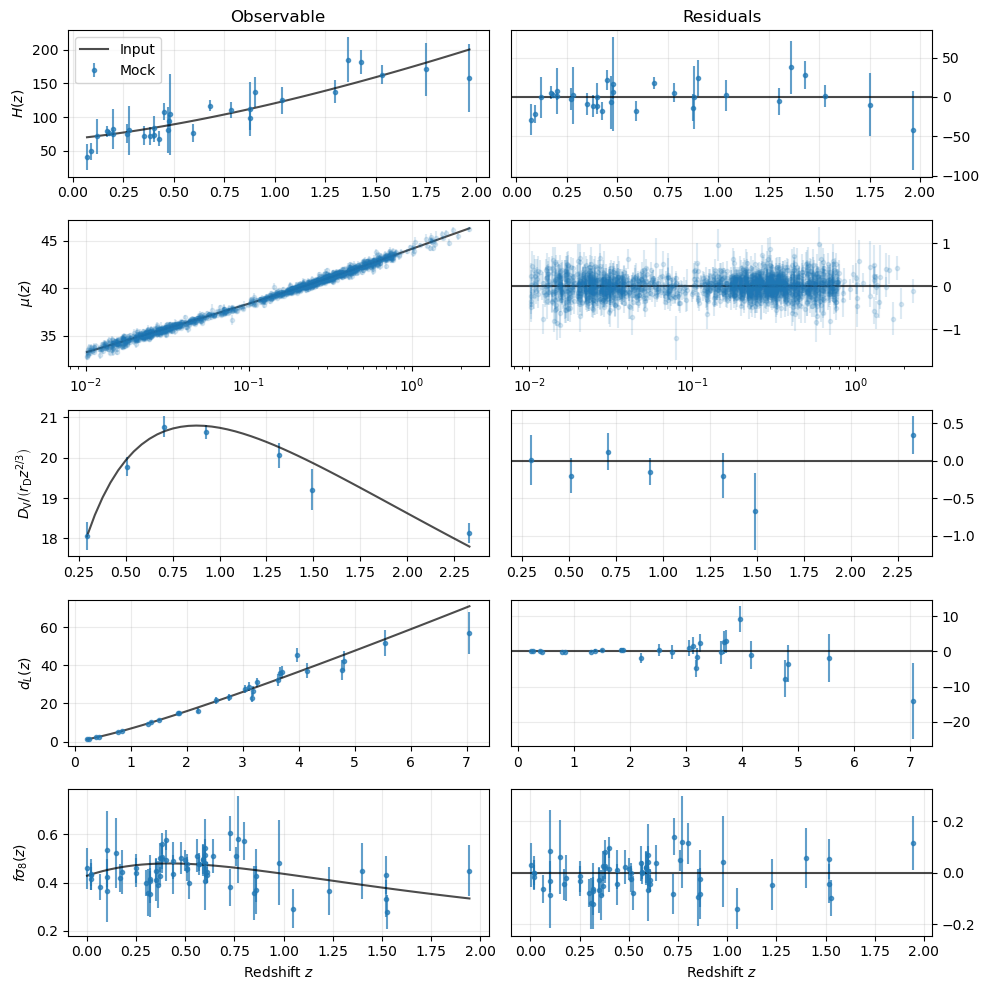

In [4]:
fig, ax=plt.subplots(nrows=5, ncols=2, figsize=(10,10))
# mock data
ax[0,0].errorbar(z_h, Hz_h, yerr=errHz_h, fmt='.', alpha=0.7, label='Mock')
ax[0,1].errorbar(z_h, Hz_h-cosmo.H(z_h).value, yerr=errHz_h, fmt='.', alpha=0.7)

ax[1,0].errorbar(z_sn, muz_sn, yerr=errmuz_sn, fmt='.', alpha=0.15)
ax[1,1].errorbar(z_sn, muz_sn-cosmo.distmod(z_sn).value, yerr=errmuz_sn, fmt='.', alpha=0.15)

# compute bao dVrdz_apy(z, cosmo, rd_fid=147.46)
ax[2,0].errorbar(z_bao, DVrdz_bao/(z_bao**(2/3)), yerr=errDVrdz_bao/z_bao**(2/3), fmt='.', alpha=0.7)
ax[2,1].errorbar(z_bao, (DVrdz_bao - dVrdz_apy(z_bao, cosmo, rd_fid=147.46))/(z_bao**(2/3)), \
                 yerr=errDVrdz_bao/z_bao**(2/3), fmt='.', alpha=0.7)

ax[3,0].errorbar(z_bs, dLz_bs, yerr=errdLz_bs, fmt='.', alpha=0.7)
ax[3,1].errorbar(z_bs, dLz_bs-cosmo.luminosity_distance(z_bs).value/1000, yerr=errdLz_bs, fmt='.', alpha=0.7)

ax[4,0].errorbar(z_g, fs8z_g, yerr=errfs8z_g, fmt='.', alpha=0.7)
ax[4,1].errorbar(z_g, fs8z_g-fs8z_apy(z_g, cosmo, s8=s8, de_model='no pert', k2cs2=1e-10, hh=1e-10), \
                 yerr=errfs8z_g, fmt='.', alpha=0.7)

# input/theory
ax[0,0].plot(np.linspace(min(z_h), max(z_h)), \
             cosmo.H(np.linspace(min(z_h), max(z_h))).value, 'k-', alpha=0.7, label='Input')
ax[0,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[1,0].plot(np.linspace(min(z_sn), max(z_sn)), \
             cosmo.distmod(np.linspace(min(z_sn), max(z_sn))).value, 'k-', alpha=0.7)
ax[1,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[2,0].plot(np.linspace(min(z_bao), max(z_bao)), \
             dVrdz_apy(np.linspace(min(z_bao), max(z_bao)), cosmo, rd_fid=147.46)\
             /(np.linspace(min(z_bao), max(z_bao))**(2/3)), 'k-', alpha=0.7)
ax[2,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[3,0].plot(np.linspace(min(z_bs), max(z_bs)), \
             cosmo.luminosity_distance(np.linspace(min(z_bs), max(z_bs))).value/1000, 'k-', alpha=0.7)
ax[3,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[4,0].plot(np.linspace(min(z_g), max(z_g)), \
             fs8z_apy(np.linspace(min(z_g), max(z_g)), cosmo, \
                      s8=s8, de_model='no pert', k2cs2=1e-10, hh=1e-10), 'k-', alpha=0.7)
ax[4,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[0,0].set_title(r'Observable'); ax[0,1].set_title(r'Residuals')
ax[0,0].set_ylabel(r'$H(z)$'); ax[1,0].set_ylabel(r'$\mu(z)$')
ax[2,0].set_ylabel(r'$D_{\rm V}/\left( r_{\rm D} z^{2/3} \right)$'); ax[3,0].set_ylabel(r'$d_L(z)$')
ax[4,0].set_ylabel(r'$f \sigma_8(z)$')

ax[4,0].set_xlabel(r'Redshift $z$'); ax[4,1].set_xlabel(r'Redshift $z$')
ax[1,0].set_xscale('log'); ax[1,1].set_xscale('log')
[ax[i,1].yaxis.tick_right() for i in range(5)]
[ax[i,j].grid(True, alpha=0.25) for i in range(5) for j in range(2)]
ax[0,0].legend(loc='upper left', prop={'size': 10})
fig.tight_layout()
plt.show()

### Multiple mocks, fixed random seed

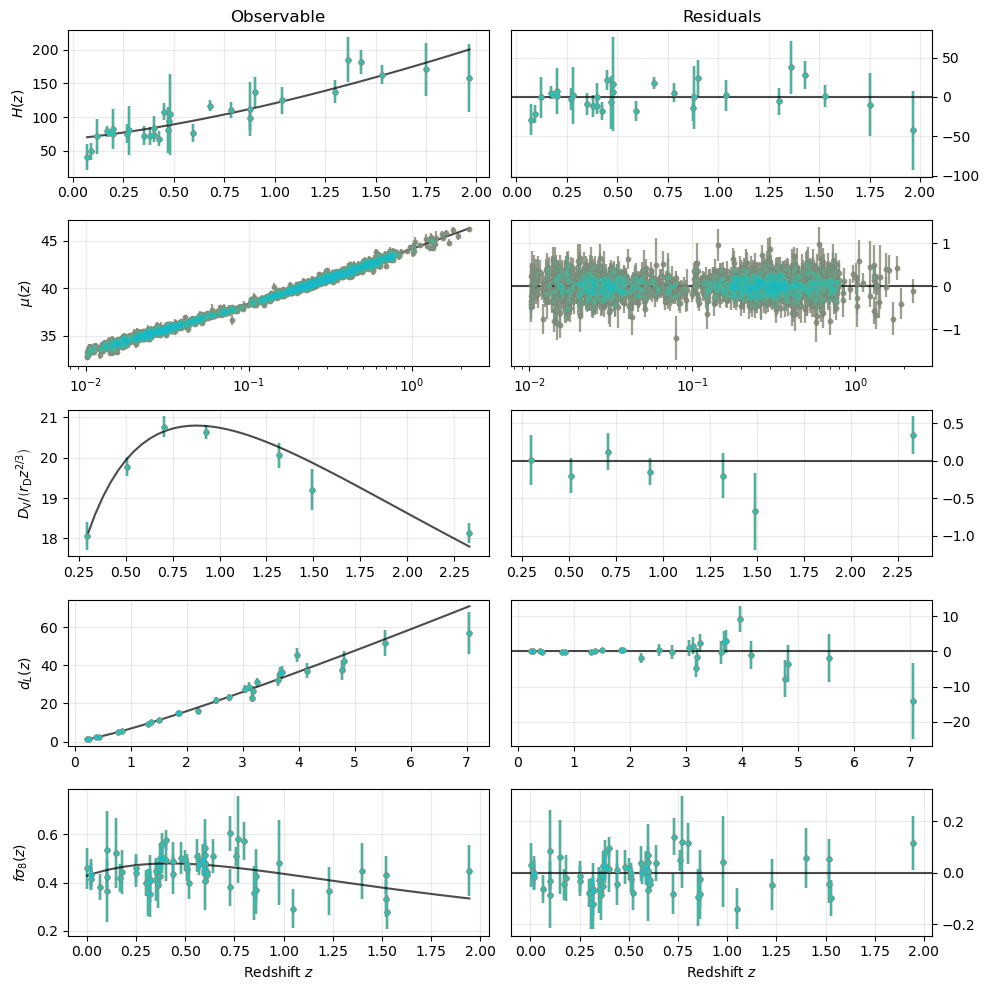

In [5]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, Ok0, w0, wa, s8 = 70, 0.3, 0, -1, 0, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, Ok0, w0, wa, s8 = 67.74, 0.3095, 0, -0.997, 0, 0.834
cosmo=w0waCDM(H0=H0, Om0=Om0, Ode0=1-Om0-Ok0, w0=w0, wa=wa) # baseline astropy model


fig, ax=plt.subplots(nrows=5, ncols=2, figsize=(10,10))

for rs in range(10):
    fixed_rs=14000605
    gw_cosmo=CosmoLearn([H0, Om0, Ok0, w0, wa, s8], seed=fixed_rs)
    gw_cosmo.set_cosmo()

    z_h, Hz_h, errHz_h=gw_cosmo.make_cosmic_chronometers_like()
    z_sn, muz_sn, errmuz_sn=gw_cosmo.make_pantheon_plus_like()
    z_bao, DVrdz_bao, errDVrdz_bao=gw_cosmo.make_desi1_like()
    z_bs, dLz_bs, errdLz_bs=gw_cosmo.make_bright_sirens_mock(pop_model='Pop III', years=5)
    z_g, fs8z_g, errfs8z_g=gw_cosmo.make_rsd_like(de_model='no pert', k2cs2=1e-10, hh=1e-10)

    # mock data
    ax[0,0].errorbar(z_h, Hz_h, yerr=errHz_h, fmt='.', alpha=0.7)
    ax[0,1].errorbar(z_h, Hz_h-cosmo.H(z_h).value, yerr=errHz_h, fmt='.', alpha=0.7)

    ax[1,0].errorbar(z_sn, muz_sn, yerr=errmuz_sn, fmt='.', alpha=0.15)
    ax[1,1].errorbar(z_sn, muz_sn-cosmo.distmod(z_sn).value, yerr=errmuz_sn, fmt='.', alpha=0.15)

    # compute bao dVrdz_apy(z, cosmo, rd_fid=147.46)
    ax[2,0].errorbar(z_bao, DVrdz_bao/(z_bao**(2/3)), yerr=errDVrdz_bao/z_bao**(2/3), fmt='.', alpha=0.7)
    ax[2,1].errorbar(z_bao, (DVrdz_bao - dVrdz_apy(z_bao, cosmo, rd_fid=147.46))/(z_bao**(2/3)), \
                    yerr=errDVrdz_bao/z_bao**(2/3), fmt='.', alpha=0.7)

    ax[3,0].errorbar(z_bs, dLz_bs, yerr=errdLz_bs, fmt='.', alpha=0.7)
    ax[3,1].errorbar(z_bs, dLz_bs-cosmo.luminosity_distance(z_bs).value/1000, yerr=errdLz_bs, fmt='.', alpha=0.7)

    ax[4,0].errorbar(z_g, fs8z_g, yerr=errfs8z_g, fmt='.', alpha=0.7)
    ax[4,1].errorbar(z_g, fs8z_g-fs8z_apy(z_g, cosmo, s8=s8, de_model='no pert', k2cs2=1e-10, hh=1e-10), \
                     yerr=errfs8z_g, fmt='.', alpha=0.7)

# input/theory
ax[0,0].plot(np.linspace(min(z_h), max(z_h)), \
             cosmo.H(np.linspace(min(z_h), max(z_h))).value, 'k-', alpha=0.7)
ax[0,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[1,0].plot(np.linspace(min(z_sn), max(z_sn)), \
             cosmo.distmod(np.linspace(min(z_sn), max(z_sn))).value, 'k-', alpha=0.7)
ax[1,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[2,0].plot(np.linspace(min(z_bao), max(z_bao)), \
             dVrdz_apy(np.linspace(min(z_bao), max(z_bao)), cosmo, rd_fid=147.46)\
             /(np.linspace(min(z_bao), max(z_bao))**(2/3)), 'k-', alpha=0.7)
ax[2,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[3,0].plot(np.linspace(min(z_bs), max(z_bs)), \
             cosmo.luminosity_distance(np.linspace(min(z_bs), max(z_bs))).value/1000, 'k-', alpha=0.7)
ax[3,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[4,0].plot(np.linspace(min(z_g), max(z_g)), \
             fs8z_apy(np.linspace(min(z_g), max(z_g)), cosmo, \
                      s8=s8, de_model='no pert', k2cs2=1e-10, hh=1e-10), 'k-', alpha=0.7)
ax[4,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[0,0].set_title(r'Observable'); ax[0,1].set_title(r'Residuals')
ax[0,0].set_ylabel(r'$H(z)$'); ax[1,0].set_ylabel(r'$\mu(z)$')
ax[2,0].set_ylabel(r'$D_{\rm V}/\left( r_{\rm D} z^{2/3} \right)$'); ax[3,0].set_ylabel(r'$d_L(z)$')
ax[4,0].set_ylabel(r'$f \sigma_8(z)$')

ax[4,0].set_xlabel(r'Redshift $z$'); ax[4,1].set_xlabel(r'Redshift $z$')
ax[1,0].set_xscale('log'); ax[1,1].set_xscale('log')
[ax[i,1].yaxis.tick_right() for i in range(5)]
[ax[i,j].grid(True, alpha=0.25) for i in range(5) for j in range(2)]
fig.tight_layout()
plt.show()

### Multiple mocks, changing random seed

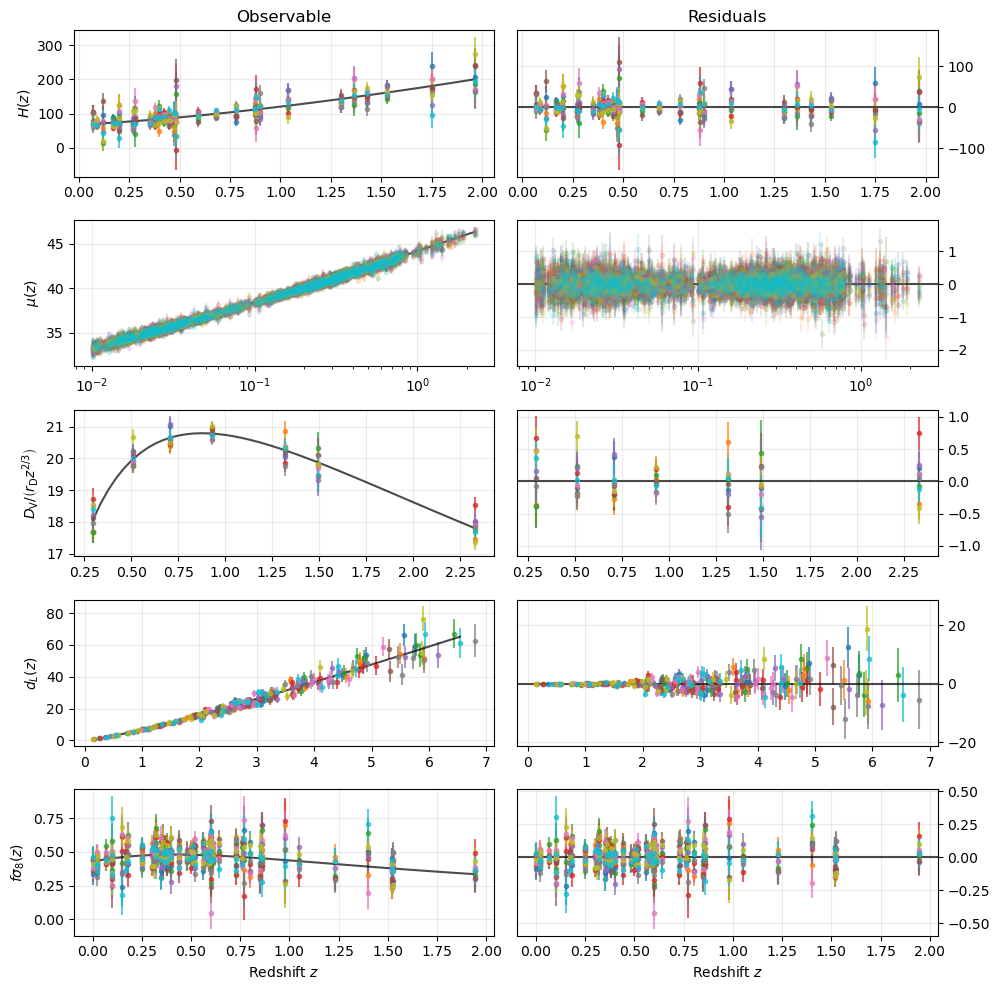

In [6]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, Ok0, w0, wa, s8 = 70, 0.3, 0, -1, 0, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, Ok0, w0, wa, s8 = 67.74, 0.3095, 0, -0.997, 0, 0.834
cosmo=w0waCDM(H0=H0, Om0=Om0, Ode0=1-Om0-Ok0, w0=w0, wa=wa) # baseline astropy model


fig, ax=plt.subplots(nrows=5, ncols=2, figsize=(10,10))

for rs in range(10):
    gw_cosmo=CosmoLearn([H0, Om0, Ok0, w0, wa, s8], seed=rs)
    gw_cosmo.set_cosmo()

    z_h, Hz_h, errHz_h=gw_cosmo.make_cosmic_chronometers_like()
    z_sn, muz_sn, errmuz_sn=gw_cosmo.make_pantheon_plus_like()
    z_bao, DVrdz_bao, errDVrdz_bao=gw_cosmo.make_desi1_like()
    z_bs, dLz_bs, errdLz_bs=gw_cosmo.make_bright_sirens_mock(pop_model='Pop III', years=5)
    z_g, fs8z_g, errfs8z_g=gw_cosmo.make_rsd_like(de_model='no pert', k2cs2=1e-10, hh=1e-10)

    # mock data
    ax[0,0].errorbar(z_h, Hz_h, yerr=errHz_h, fmt='.', alpha=0.7)
    ax[0,1].errorbar(z_h, Hz_h-cosmo.H(z_h).value, yerr=errHz_h, fmt='.', alpha=0.7)

    ax[1,0].errorbar(z_sn, muz_sn, yerr=errmuz_sn, fmt='.', alpha=0.15)
    ax[1,1].errorbar(z_sn, muz_sn-cosmo.distmod(z_sn).value, yerr=errmuz_sn, fmt='.', alpha=0.15)

    # compute bao dVrdz_apy(z, cosmo, rd_fid=147.46)
    ax[2,0].errorbar(z_bao, DVrdz_bao/(z_bao**(2/3)), yerr=errDVrdz_bao/z_bao**(2/3), fmt='.', alpha=0.7)
    ax[2,1].errorbar(z_bao, (DVrdz_bao - dVrdz_apy(z_bao, cosmo, rd_fid=147.46))/(z_bao**(2/3)), \
                     yerr=errDVrdz_bao/z_bao**(2/3), fmt='.', alpha=0.7)

    ax[3,0].errorbar(z_bs, dLz_bs, yerr=errdLz_bs, fmt='.', alpha=0.7)
    ax[3,1].errorbar(z_bs, dLz_bs-cosmo.luminosity_distance(z_bs).value/1000, yerr=errdLz_bs, fmt='.', alpha=0.7)

    ax[4,0].errorbar(z_g, fs8z_g, yerr=errfs8z_g, fmt='.', alpha=0.7)
    ax[4,1].errorbar(z_g, fs8z_g-fs8z_apy(z_g, cosmo, s8=s8, de_model='no pert', k2cs2=1e-10, hh=1e-10), \
                     yerr=errfs8z_g, fmt='.', alpha=0.7)

# input/theory
ax[0,0].plot(np.linspace(min(z_h), max(z_h)), \
             cosmo.H(np.linspace(min(z_h), max(z_h))).value, 'k-', alpha=0.7)
ax[0,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[1,0].plot(np.linspace(min(z_sn), max(z_sn)), \
             cosmo.distmod(np.linspace(min(z_sn), max(z_sn))).value, 'k-', alpha=0.7)
ax[1,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[2,0].plot(np.linspace(min(z_bao), max(z_bao)), \
             dVrdz_apy(np.linspace(min(z_bao), max(z_bao)), cosmo, rd_fid=147.46)\
             /(np.linspace(min(z_bao), max(z_bao))**(2/3)), 'k-', alpha=0.7)
ax[2,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[3,0].plot(np.linspace(min(z_bs), max(z_bs)), \
             cosmo.luminosity_distance(np.linspace(min(z_bs), max(z_bs))).value/1000, 'k-', alpha=0.7)
ax[3,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[4,0].plot(np.linspace(min(z_g), max(z_g)), \
             fs8z_apy(np.linspace(min(z_g), max(z_g)), cosmo, \
                      s8=s8, de_model='no pert', k2cs2=1e-10, hh=1e-10), 'k-', alpha=0.7)
ax[4,1].axhline(0, ls='-', color='k', alpha=0.7)

ax[0,0].set_title(r'Observable'); ax[0,1].set_title(r'Residuals')
ax[0,0].set_ylabel(r'$H(z)$'); ax[1,0].set_ylabel(r'$\mu(z)$')
ax[2,0].set_ylabel(r'$D_{\rm V}/\left( r_{\rm D} z^{2/3} \right)$'); ax[3,0].set_ylabel(r'$d_L(z)$')
ax[4,0].set_ylabel(r'$f \sigma_8(z)$')

ax[4,0].set_xlabel(r'Redshift $z$'); ax[4,1].set_xlabel(r'Redshift $z$')
ax[1,0].set_xscale('log'); ax[1,1].set_xscale('log')
[ax[i,1].yaxis.tick_right() for i in range(5)]
[ax[i,j].grid(True, alpha=0.25) for i in range(5) for j in range(2)]
fig.tight_layout()
plt.show()

### One Mock: Train + Test

In [7]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
H0, Om0, Ok0, w0, wa, s8 = 70, 0.3, 0, -1, 0, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
# H0, Om0, Ok0, w0, wa, s8 = 67.74, 0.3095, 0, -0.997, 0, 0.834
cosmo=w0waCDM(H0=H0, Om0=Om0, Ode0=1-Om0-Ok0, w0=w0, wa=wa) # baseline astropy model

gw_cosmo=CosmoLearn([H0, Om0, Ok0, w0, wa, s8], seed=14000605)
gw_cosmo.set_cosmo()

z_h, Hz_h, errHz_h=gw_cosmo.make_cosmic_chronometers_like()
z_sn, muz_sn, errmuz_sn=gw_cosmo.make_pantheon_plus_like()
z_bao, DVrdz_bao, errDVrdz_bao=gw_cosmo.make_desi1_like()
z_bs, dLz_bs, errdLz_bs=gw_cosmo.make_bright_sirens_mock(pop_model='Pop III', years=5)
z_g, fs8z_g, errfs8z_g=gw_cosmo.make_rsd_like(de_model='no pert', k2cs2=1e-10, hh=1e-10)

gw_cosmo.mock_data.keys()

dict_keys(['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', 'BrightSirens', 'RedshiftSpaceDistorsions'])

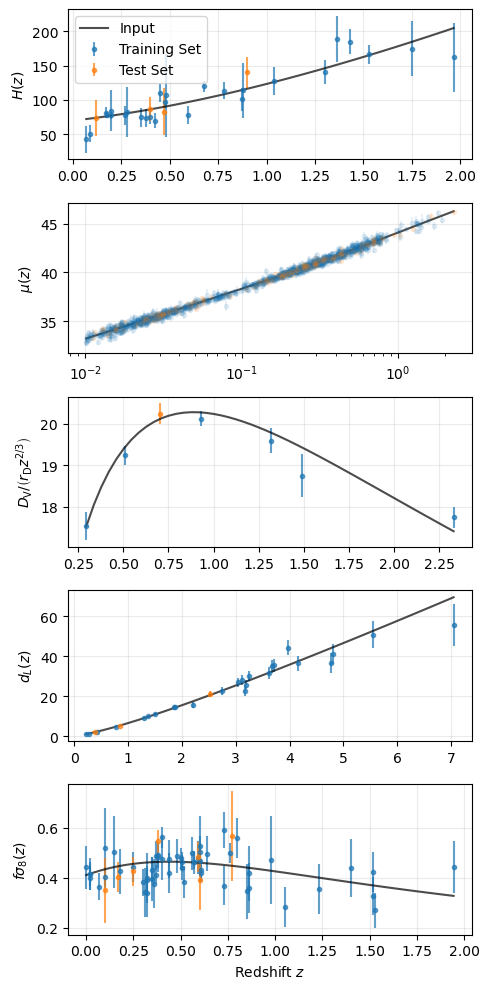

In [8]:
fig, ax=plt.subplots(nrows=5, figsize=(5,10))
# mock data
gw_cosmo.plot_train_test_data(ax[0], 'CosmicChronometers', fmt='.', alpha=0.7)
gw_cosmo.plot_train_test_data(ax[1], 'SuperNovae', fmt='.', alpha=0.1)
gw_cosmo.plot_train_test_data(ax[2], 'BaryonAcousticOscillations', fmt='.', alpha=0.7)
gw_cosmo.plot_train_test_data(ax[3], 'BrightSirens', fmt='.', alpha=0.7)
gw_cosmo.plot_train_test_data(ax[4], 'RedshiftSpaceDistorsions', fmt='.', alpha=0.7)

# input/theory
ax[0].plot(np.linspace(min(z_h), max(z_h)), \
           cosmo.H(np.linspace(min(z_h), max(z_h))).value, 'k-', alpha=0.7, label='Input')

ax[1].plot(np.linspace(min(z_sn), max(z_sn)), \
           cosmo.distmod(np.linspace(min(z_sn), max(z_sn))).value, 'k-', alpha=0.7)

ax[2].plot(np.linspace(min(z_bao), max(z_bao)), \
           dVrdz_apy(np.linspace(min(z_bao), max(z_bao)), cosmo, rd_fid=147.46)\
           /(np.linspace(min(z_bao), max(z_bao))**(2/3)), 'k-', alpha=0.7)

ax[3].plot(np.linspace(min(z_bs), max(z_bs)), \
           cosmo.luminosity_distance(np.linspace(min(z_bs), max(z_bs))).value/1000, 'k-', alpha=0.7)

ax[4].plot(np.linspace(min(z_g), max(z_g)), \
           fs8z_apy(np.linspace(min(z_g), max(z_g)), cosmo, \
                    s8=s8, de_model='no pert', k2cs2=1e-10, hh=1e-10), 'k-', alpha=0.7)

ax[0].set_ylabel(r'$H(z)$'); ax[1].set_ylabel(r'$\mu(z)$')
ax[2].set_ylabel(r'$D_{\rm V}/\left( r_{\rm D} z^{2/3} \right)$'); ax[3].set_ylabel(r'$d_L(z)$')
ax[4].set_ylabel(r'$f \sigma_8(z)$')

ax[4].set_xlabel(r'Redshift $z$')
ax[1].set_xscale('log')
[ax[i].grid(True, alpha=0.25) for i in range(5)]
ax[0].legend(loc='upper left', prop={'size': 10})
fig.tight_layout()
plt.show()

### ANN/GP/BRR Reconstruction

In [12]:
ann_model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[1]),
                                 tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2()),
                                 tf.keras.layers.Dense(2),])
ann_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.MeanSquaredError(),)
ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
 dense_1 (Dense)             (None, 100)               200       
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 404
Trainable params: 404
Non-trainable params: 0
_________________________________________________________________


In [30]:
gw_cosmo.mock_data.keys()
# train_data=gw_cosmo.mock_data['CosmicChronometers']['train']
train_data=gw_cosmo.mock_data['SuperNovae']['train']
# train_data=gw_cosmo.mock_data['BaryonAcousticOscillations']['train']
x=train_data['x']; y=np.column_stack((train_data['y'], train_data['yerr']))

num_samples=len(x)
n = int(0.9 * num_samples)
print('Number of training samples:', n)
print('Number of validation samples:', num_samples - n)
print()

x_train = x[:n]; y_train = y[:n]
x_validation = x[n:]; y_validation= y[n:]

Number of training samples: 1287
Number of validation samples: 144



In [34]:
n_epochs=3000
ann_history = ann_model.fit(x_train, y_train, epochs=n_epochs, validation_data=(x_validation, y_validation))

Epoch 1/3000
41/41 [==============================] - 0s 6ms/step - loss: 0.0442 - val_loss: 0.0386
Epoch 2/3000
41/41 [==============================] - 0s 1ms/step - loss: 0.0428 - val_loss: 0.0378
Epoch 3/3000
41/41 [==============================] - 0s 919us/step - loss: 0.0438 - val_loss: 0.0441
Epoch 4/3000
41/41 [==============================] - 0s 869us/step - loss: 0.0433 - val_loss: 0.0375
Epoch 5/3000
41/41 [==============================] - 0s 843us/step - loss: 0.0439 - val_loss: 0.0381
Epoch 6/3000
41/41 [==============================] - 0s 832us/step - loss: 0.0415 - val_loss: 0.0448
Epoch 7/3000
41/41 [==============================] - 0s 793us/step - loss: 0.0428 - val_loss: 0.0386
Epoch 8/3000
41/41 [==============================] - 0s 782us/step - loss: 0.0415 - val_loss: 0.0378
Epoch 9/3000
41/41 [==============================] - 0s 809us/step - loss: 0.0441 - val_loss: 0.0403
Epoch 10/3000
41/41 [==============================] - 0s 785us/step - loss: 0.0444 - 

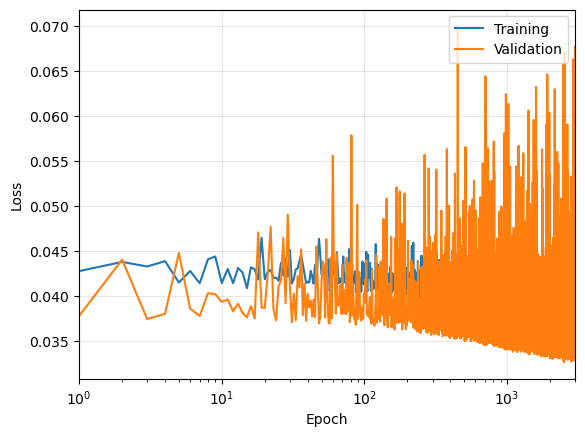

In [37]:
fig, ax=plt.subplots()
ax.plot(ann_history.history['loss'], label='Training')
ax.plot(ann_history.history['val_loss'], label='Validation')
ax.legend(loc='upper right', prop={'size': 10})
ax.set_xlim(1, n_epochs)
ax.set_yscale('log'); ax.set_xscale('log')
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
plt.show()

32/32 [==============================] - 0s 404us/step


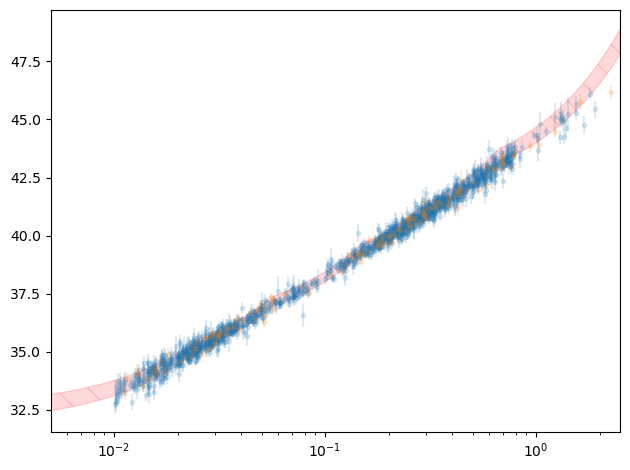

In [40]:
# x_rec=np.linspace(0.2, 2.4, 1000)
x_rec=np.logspace(-2.3, np.log10(2.5), 1000)
y_rec = ann_model.predict(x_rec)
ymean_rec = y_rec[:, 0]; yerr_rec = y_rec[:, 1]


fig, ax=plt.subplots()
# gw_cosmo.plot_train_test_data(ax, 'CosmicChronometers', fmt='.', alpha=0.7)
gw_cosmo.plot_train_test_data(ax, 'SuperNovae', fmt='.', alpha=0.15)
ax.fill_between(x_rec, ymean_rec-yerr_rec, ymean_rec+yerr_rec, \
                facecolor='red', edgecolor='red', alpha=0.15, hatch='\\', label='ANN')

# for bao below
# gw_cosmo.plot_train_test_data(ax, 'BaryonAcousticOscillations', fmt='.', alpha=0.7)
# ax.fill_between(x_rec, (ymean_rec-yerr_rec)/(x_rec**(2/3)), (ymean_rec+yerr_rec)/(x_rec**(2/3)), \
#                 facecolor='red', edgecolor='red', alpha=0.25, hatch='\\', label='ANN')

ax.set_xlim(min(x_rec), max(x_rec))
ax.set_xscale('log')
# ax.set_ylabel(r'$H(z)$'); ax.set_xlabel(r'Redshift $z$')
# ax.legend(loc='upper left', prop={'size': 10})
fig.tight_layout()
plt.show()

### Inference MCMC and GA

In [3]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, Ok0, w0, wa, s8 = 70, 0.3, 0, -1, 0, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, Ok0, w0, wa, s8 = 67.74, 0.3095, 0, -0.997, 0, 0.834
cosmo=w0waCDM(H0=H0, Om0=Om0, Ode0=1-Om0-Ok0, w0=w0, wa=wa) # baseline astropy model

gw_cosmo=CosmoLearn([H0, Om0, Ok0, w0, wa, s8], seed=14000605)
gw_cosmo.set_cosmo()

z_h, Hz_h, errHz_h=gw_cosmo.make_cosmic_chronometers_like()
z_sn, muz_sn, errmuz_sn=gw_cosmo.make_pantheon_plus_like()
z_bao, DVrdz_bao, errDVrdz_bao=gw_cosmo.make_desi1_like()
z_bs, dLz_bs, errdLz_bs=gw_cosmo.make_bright_sirens_mock(pop_model='Pop III', years=5)
z_g, fs8z_g, errfs8z_g=gw_cosmo.make_rsd_like(de_model='no pert', k2cs2=1e-10, hh=1e-10)

gw_cosmo.mock_data.keys()

dict_keys(['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', 'BrightSirens', 'RedshiftSpaceDistorsions'])

In [4]:
prior_dict={'H0_min': 0, 'H0_max': 100, 'Om0_min': 0, 'Om0_max': 1, \
            'w0_min': -10, 'w0_max': 10, 's8_min': 0.2, 's8_max': 1.5}
rd_fid_prior={'mu': 147.46, 'sigma': 0.28}
llprob=lambda x: gw_cosmo.llprob_wcdm(x, prior_dict=prior_dict, rd_fid_prior=rd_fid_prior)

p0=[70, 0.3, -1, 0.8, 147]
nwalkers=12; dres=[0.05, 0.005, 0.01, 0.01, 0.005]; nburn=100; nmcmc=1000
mcmc_samples=gw_cosmo.get_mcmc_samples(nwalkers, dres, llprob, p0, nburn=nburn, nmcmc=nmcmc)

Optimizing initial position...
... At [ 67.99470352   0.31697949  -1.06258809   0.8152854  147.57942575]
Running MCMC...


100%|██████████| 1000/1000 [01:25<00:00, 11.75it/s]

Done.
Mean acceptance fraction: 0.5448333333333334
Total time: 93.54532122612
MCMC result:
    x[0] = 68.01651379861542 + 0.30739999640340443 - 0.28252514425119557
    x[1] = 0.3189371615744591 + 0.011878712215923848 - 0.013002396353371415
    x[2] = -1.0713812074403026 + 0.06480456797317036 - 0.06237908451554475
    x[3] = 0.8138210456725328 + 0.014588047782950309 - 0.014519472265772881
    x[4] = 147.5916829218209 + 0.2836934409448304 - 0.25891604701394044


In [5]:
prior_ga=[[prior_dict['H0_min'], prior_dict['H0_max']], [prior_dict['Om0_min'], prior_dict['Om0_max']], \
          [prior_dict['w0_min'], prior_dict['w0_max']], [prior_dict['s8_min'], prior_dict['s8_max']], \
          [rd_fid_prior['mu']-20*rd_fid_prior['sigma'], rd_fid_prior['mu']+20*rd_fid_prior['sigma']]]
fitness_func=lambda x: -2*gw_cosmo.llprob_wcdm(x, prior_dict=prior_dict, rd_fid_prior=rd_fid_prior)

ga_params={'max_num_iteration': 3000, 'population_size':100, 'mutation_probability': 0.3, \
           'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, \
           'crossover_type':'uniform', 'max_iteration_without_improv': None}
gaFisher_samples=gw_cosmo.get_gaFisher_samples(fitness_func, prior_ga, ga_params=ga_params, \
                                               llprob=llprob, nsamples=(nmcmc-nburn)*nwalkers)

||________________________________________________ 3.9% GA is running...

/home/reggie/cosmo_learn/cosmo_learn/cosmo_learn.py:187: RuntimeWarning: invalid value encountered in divide
  s8z=sigma8_0*dltz/dlt_0


||________________________________________________ 3.9% GA is running...

/home/reggie/miniconda3/envs/cosmo/lib/python3.11/site-packages/geneticalgorithm/geneticalgorithm.py:353: RuntimeWarning: invalid value encountered in subtract
  normobj=maxnorm-normobj+1


||||||||__________________________________________ 15.1% GA is running...

/home/reggie/cosmo_learn/cosmo_learn/cosmo_learn.py:176: RuntimeWarning: divide by zero encountered in divide
  hypergeom_factor=hyp2f1(alpha+1, beta+1, gamma+1, 1 - (1/Omz))/hyp2f1(alpha, beta, gamma, 1 - (1/Omz))
/home/reggie/cosmo_learn/cosmo_learn/cosmo_learn.py:189: RuntimeWarning: invalid value encountered in multiply
  return fz*s8z


||||||||||||||||__________________________________ 31.9% GA is running...

/home/reggie/cosmo_learn/cosmo_learn/cosmo_learn.py:176: RuntimeWarning: invalid value encountered in divide
  hypergeom_factor=hyp2f1(alpha+1, beta+1, gamma+1, 1 - (1/Omz))/hyp2f1(alpha, beta, gamma, 1 - (1/Omz))


 The best solution found:                                                                           
 [ 67.65230943   0.31150147  -1.00812254   0.81975324 147.58191729]

 Objective function:
 1509.6488800247698

GA-Fisher result:
    x[0] = 67.65122881634787 + 0.2816273925420347 - 0.2892654586175354
    x[1] = 0.3115368963057036 + 0.01386026374203636 - 0.01405864490378872
    x[2] = -1.0069916016218374 + 0.06053570592749691 - 0.061473428864021074
    x[3] = 0.8197136779828852 + 0.014992473046995802 - 0.01523833249393769
    x[4] = 147.5854929705469 + 0.2696290770679468 - 0.27532195971016904


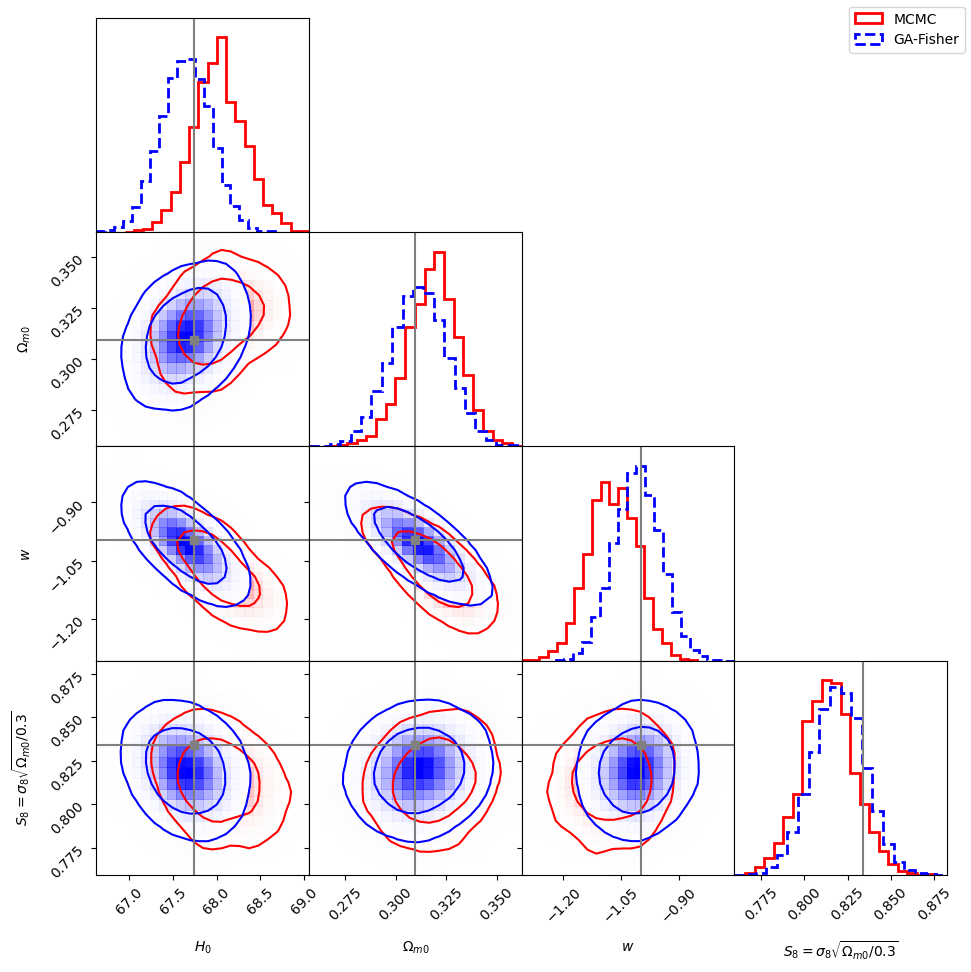

In [6]:
labels = [r'$H_0$', r'$\Omega_{m0}$', r'$w$', r'$S_8=\sigma_8 \sqrt{\Omega_{m0}/0.3}$']
params_true = [67.74, 0.3095, -0.997, 0.834]
# params_true = [70, 0.3, -1, 0.8]

corner_plot = add_corner(mcmc_samples[:,:4], labels, color='red', ls='-')
add_corner(gaFisher_samples[:,:4], labels, fig=corner_plot, color='blue', ls='--', \
           add_truth=params_true, truth_color='gray')

legend_labels = ['MCMC', 'GA-Fisher']
corner_plot.legend(legend_labels, loc='upper right')
corner_plot.tight_layout(); corner_plot.subplots_adjust(hspace=0, wspace=0)
# corner_plot.savefig('figs/corner_name.pdf', bbox_inches='tight')
plt.show()

In [7]:
def cosmo_func_wcdm(x, p, key='CosmicChronometers', de_model='no pert', k2cs2=1e-10, hh=1e-10, Tcmb0=None):
    H0, Om0, w0, s8, rd_fid=p
    if Tcmb0==None:
        Tcmb0=2.7
    Ok0=0; wa=0
    cosmo_model=w0waCDM(H0=H0, Om0=Om0, Ode0=1-Om0-Ok0, w0=w0, wa=wa, Tcmb0=Tcmb0)
    if key=='CosmicChronometers':
        return cosmo_model.H(x).value
    if key=='RedshiftSpaceDistorsions':
        return fs8z_apy(x, cosmo_model, s8, de_model=de_model, k2cs2=k2cs2, hh=hh)
    if key=='SuperNovae':
        return cosmo_model.distmod(x).value
    if key=='BaryonAcousticOscillations':
        return dVrdz_apy(x, cosmo_model, rd_fid=rd_fid)
    if key=='BrightSirens':
        return cosmo_model.luminosity_distance(x).value/1000

In [8]:
# key='CosmicChronometers'
# key='SuperNovae'
# key='RedshiftSpaceDistorsions'
key='BaryonAcousticOscillations'
# key='BrightSirens'
de_model='no pert'; k2cs2=1e-10; hh=1e-10; Tcmb0=None
x_rec=np.linspace(1e-3, 2.4, 100)
cosmo_func=lambda x, p: cosmo_func_wcdm(x, p, key=key, de_model=de_model, k2cs2=k2cs2, hh=hh, Tcmb0=Tcmb0)
x_rec, func_mean, func_err=mcreconstruct_function(cosmo_func, mcmc_samples, x_rec=x_rec, nmc=1000)

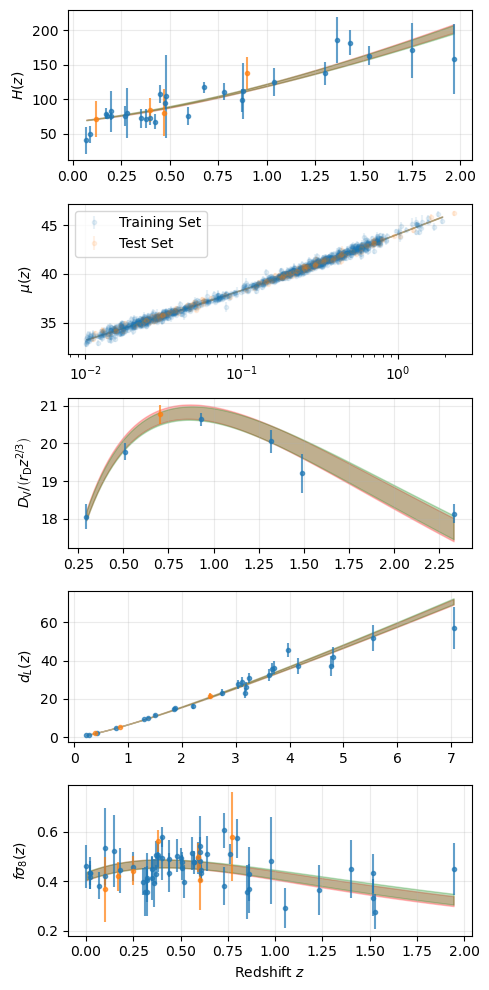

In [20]:
fig, ax=plt.subplots(nrows=5, figsize=(5,10))
# mock data
gw_cosmo.plot_train_test_data(ax[0], 'CosmicChronometers', fmt='.', alpha=0.7)
gw_cosmo.plot_train_test_data(ax[1], 'SuperNovae', fmt='.', alpha=0.1)
gw_cosmo.plot_train_test_data(ax[2], 'BaryonAcousticOscillations', fmt='.', alpha=0.7)
gw_cosmo.plot_train_test_data(ax[3], 'BrightSirens', fmt='.', alpha=0.7)
gw_cosmo.plot_train_test_data(ax[4], 'RedshiftSpaceDistorsions', fmt='.', alpha=0.7)

de_model='no pert'; k2cs2=1e-10; hh=1e-10; Tcmb0=None
n_sigma_rec=2
for i, key in enumerate(gw_cosmo.mock_data.keys()):
    cosmo_func=lambda x, p: cosmo_func_wcdm(x, p, key=key, de_model=de_model, k2cs2=k2cs2, hh=hh, Tcmb0=Tcmb0)
    x_train=gw_cosmo.mock_data[key]['train']['x']
    x_rec=np.linspace(min(x_train), max(x_train), 100)

    # mcmc reconstructions
    x_rec, func_mean, func_err=mcreconstruct_function(cosmo_func, mcmc_samples, x_rec=x_rec, nmc=1000)
    if key!='BaryonAcousticOscillations':
        ax[i].fill_between(x_rec, func_mean-n_sigma_rec*func_err, func_mean+n_sigma_rec*func_err, \
                           facecolor='red', edgecolor='red', alpha=0.25)
    if key=='BaryonAcousticOscillations':
        ax[i].fill_between(x_rec, \
                           (func_mean-n_sigma_rec*func_err)/(x_rec**(2/3)), \
                           (func_mean+n_sigma_rec*func_err)/(x_rec**(2/3)), \
                           facecolor='red', edgecolor='red', alpha=0.25)
        
    # ga-Fisher reconstruction
    x_rec, func_mean, func_err=mcreconstruct_function(cosmo_func, gaFisher_samples, x_rec=x_rec, nmc=1000)
    if key!='BaryonAcousticOscillations':
        ax[i].fill_between(x_rec, func_mean-n_sigma_rec*func_err, func_mean+n_sigma_rec*func_err, \
                           facecolor='green', edgecolor='green', alpha=0.25)
    if key=='BaryonAcousticOscillations':
        ax[i].fill_between(x_rec, \
                           (func_mean-n_sigma_rec*func_err)/(x_rec**(2/3)), \
                           (func_mean+n_sigma_rec*func_err)/(x_rec**(2/3)), \
                           facecolor='green', edgecolor='green', alpha=0.25)

ax[0].set_ylabel(r'$H(z)$'); ax[1].set_ylabel(r'$\mu(z)$')
ax[2].set_ylabel(r'$D_{\rm V}/\left( r_{\rm D} z^{2/3} \right)$'); ax[3].set_ylabel(r'$d_L(z)$')
ax[4].set_ylabel(r'$f \sigma_8(z)$')

ax[4].set_xlabel(r'Redshift $z$')
ax[1].set_xscale('log')
[ax[i].grid(True, alpha=0.25) for i in range(5)]
ax[1].legend(loc='upper left', prop={'size': 10})
fig.tight_layout()
plt.show()